In [1]:
!pip install geopandas matplotlib
!pip install folium pandas



In [2]:
# ======================================================================
# 1. IMPORTS
# ======================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

import joblib

import folium
import requests

import shap

sns.set(style="whitegrid", palette="muted")


In [3]:
# ======================================================================
# 2. LOAD DATA
# ======================================================================

df = pd.read_csv("genus_data.csv")

print("Shape:", df.shape)
df.head()


Shape: (1772, 16)


Genus         Family           Order   HybProp  Hyb_Ratio     perc_per  \
0     Abies       Pinaceae       Pinophyta  0.362319   0.041667            1   
1   Abronia  Nyctaginaceae  Caryophyllales  4.166667   0.312500       0.6875   
2  Abutilon      Malvaceae        Malvales  0.000000   0.000000  0.763157895   
3    Acacia       Fabaceae         Fabales  0.208189   0.136364            1   
4    Acaena       Rosaceae         Rosales  8.888889   0.400000            1   

     perc_wood   perc_ag floral_symm mating_system repro_syndrome  \
0            1  0.004762           .             1              1   
1            0  0.005063           .             .              .   
2  0.394736842  0.006154           0             1              1   
3            1  0.096495           0             .              .   
4            0  0.001060           .             .            0.5   

  pollination_syndrome      RedList      tavg      C_value   CV_C_value  
0                    0  0.695652174    0.8674  17.23266667  9.085723529  
1                    .            .         .            .            .  
2                    1          3.5     0.057        1.245            0  
3                    1          1.5  0.807875  1.186321839  31.78010935  
4                    .            .         .         0.33            .

In [4]:
# ======================================================================
# 3. CLEAN NUMERIC COLUMNS
# ======================================================================

numeric_cols = ['C_value', 'tavg', 'perc_ag', 'perc_per', 'HybProp', 'Hyb_Ratio']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col].fillna(df[col].median(), inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1772 entries, 0 to 1771
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Genus                 1772 non-null   object 
 1   Family                1772 non-null   object 
 2   Order                 1772 non-null   object 
 3   HybProp               1772 non-null   float64
 4   Hyb_Ratio             1772 non-null   float64
 5   perc_per              1772 non-null   float64
 6   perc_wood             1772 non-null   object 
 7   perc_ag               1772 non-null   float64
 8   floral_symm           1772 non-null   object 
 9   mating_system         1772 non-null   object 
 10  repro_syndrome        1772 non-null   object 
 11  pollination_syndrome  1772 non-null   object 
 12  RedList               1772 non-null   object 
 13  tavg                  1772 non-null   float64
 14  C_value               1772 non-null   float64
 15  CV_C_value           

C:\Users\khaak\AppData\Local\Temp\ipykernel_35528\1685914084.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


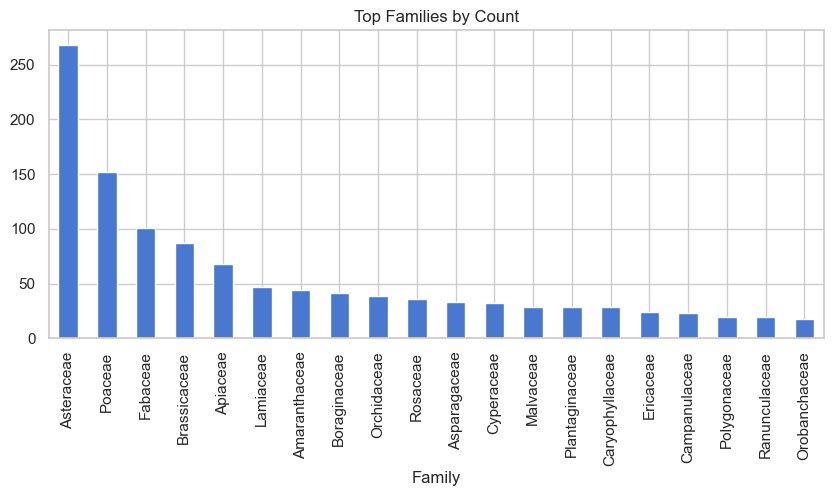

In [5]:
df['Family'].value_counts().head(20).plot(kind='bar', figsize=(10,4))
plt.title("Top Families by Count")
plt.show()


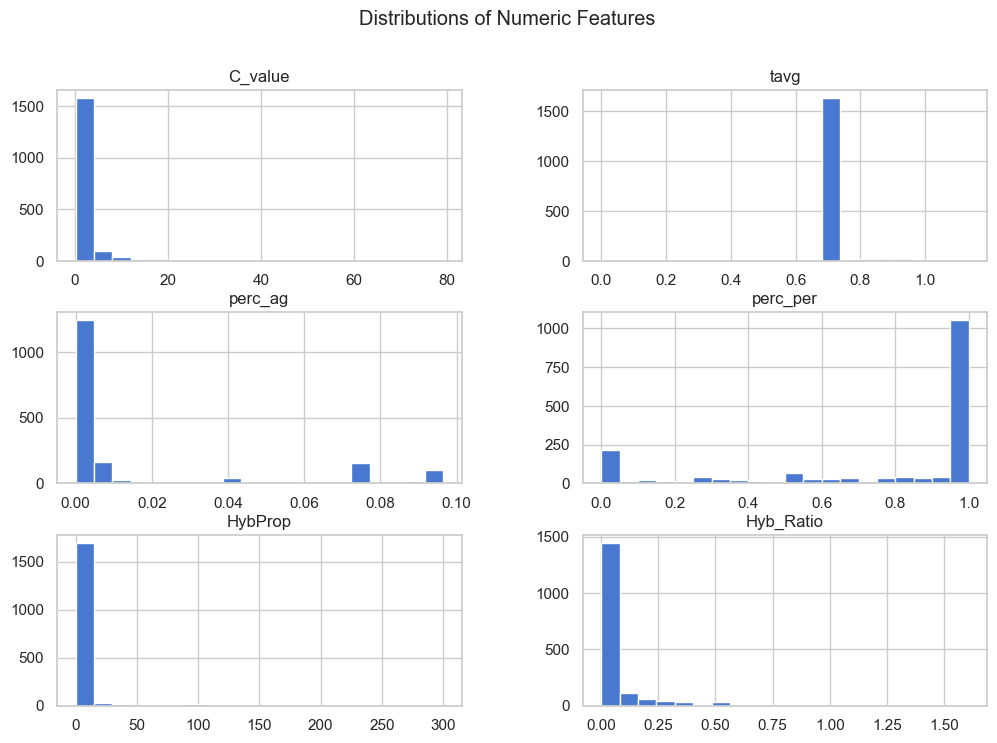

In [6]:
df[numeric_cols].hist(figsize=(12,8), bins=20)
plt.suptitle("Distributions of Numeric Features")
plt.show()


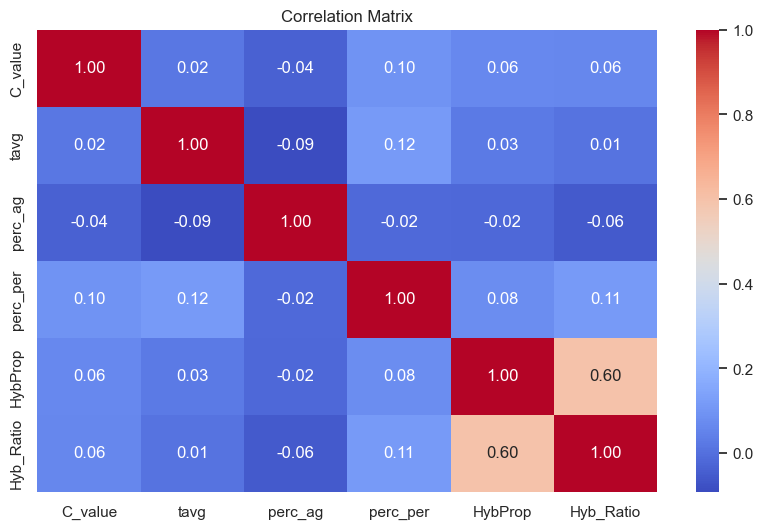

In [7]:
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [8]:
# ======================================================================
# 5. PREPARE PAIR DATA
# ======================================================================

core_features = ['C_value', 'tavg', 'perc_ag', 'perc_per', 'HybProp', 'Hyb_Ratio']

imputer = SimpleImputer(strategy='median')

df_imputed = df[['Genus', 'Family'] + core_features].copy()
df_imputed[core_features] = imputer.fit_transform(df_imputed[core_features])

N_GENERA = len(df_imputed)
N_PAIRS = 5000

np.random.seed(42)
idx_A = np.random.randint(0, N_GENERA, N_PAIRS)
idx_B = np.random.randint(0, N_GENERA, N_PAIRS)

mask = idx_A != idx_B
idx_A, idx_B = idx_A[mask], idx_B[mask]
N_PAIRS = len(idx_A)

df_pair = pd.DataFrame({
    'Genus_A': df_imputed.iloc[idx_A]['Genus'].values,
    'Genus_B': df_imputed.iloc[idx_B]['Genus'].values,
    'Family_A': df_imputed.iloc[idx_A]['Family'].values,
    'Family_B': df_imputed.iloc[idx_B]['Family'].values,
    'C_value_A': df_imputed.iloc[idx_A]['C_value'].values,
    'C_value_B': df_imputed.iloc[idx_B]['C_value'].values,
    'tavg_A': df_imputed.iloc[idx_A]['tavg'].values,
    'tavg_B': df_imputed.iloc[idx_B]['tavg'].values,
    'perc_ag_A': df_imputed.iloc[idx_A]['perc_ag'].values,
    'perc_ag_B': df_imputed.iloc[idx_B]['perc_ag'].values,
    'perc_per_A': df_imputed.iloc[idx_A]['perc_per'].values,
    'perc_per_B': df_imputed.iloc[idx_B]['perc_per'].values,
    'HybProp_A': df_imputed.iloc[idx_A]['HybProp'].values,
    'HybProp_B': df_imputed.iloc[idx_B]['HybProp'].values
})


In [9]:
# ======================================================================
# 6. FEATURE ENGINEERING (6 FEATURES)
# ======================================================================

df_pair['C_value_ABS_DIFF'] = np.abs(df_pair['C_value_A'] - df_pair['C_value_B'])
df_pair['C_value_RATIO'] = df_pair[['C_value_A','C_value_B']].max(axis=1) / df_pair[['C_value_A','C_value_B']].min(axis=1)
df_pair['Same_Family'] = (df_pair['Family_A'] == df_pair['Family_B']).astype(int)
df_pair['tavg_ABS_DIFF'] = np.abs(df_pair['tavg_A'] - df_pair['tavg_B'])
df_pair['perc_ag_SUM'] = df_pair['perc_ag_A'] + df_pair['perc_ag_B']
df_pair['perc_per_SUM'] = df_pair['perc_per_A'] + df_pair['perc_per_B']

df_pair['Hybridization_Score'] = (df_pair['HybProp_A'] + df_pair['HybProp_B']) / 2
threshold = 0.05
df_pair['Hybridization_Success'] = (df_pair['Hybridization_Score'] > threshold).astype(int)



In [10]:
# ======================================================================
# 8. TRAIN-TEST SPLIT
# ======================================================================

features = [
    'C_value_ABS_DIFF', 'C_value_RATIO', 'Same_Family',
    'tavg_ABS_DIFF', 'perc_ag_SUM', 'perc_per_SUM'
]

X = df_pair[features]
y = df_pair['Hybridization_Success']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


In [11]:
# ======================================================================
# 9. TRAIN MODEL
# ======================================================================

rf_classifier = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    class_weight='balanced',
    random_state=42
)

rf_classifier.fit(X_train_imputed, y_train)

Y_pred_proba = rf_classifier.predict_proba(X_test_imputed)[:, 1]
auc_score = roc_auc_score(y_test, Y_pred_proba)
print("AUC Score:", auc_score)


AUC Score: 0.6942610950254372


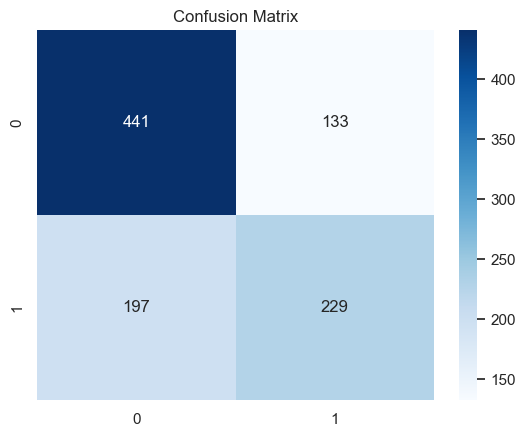

              precision    recall  f1-score   support

           0       0.69      0.77      0.73       574
           1       0.63      0.54      0.58       426

    accuracy                           0.67      1000
   macro avg       0.66      0.65      0.65      1000
weighted avg       0.67      0.67      0.67      1000



In [12]:
preds = (Y_pred_proba > 0.5).astype(int)

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, preds))


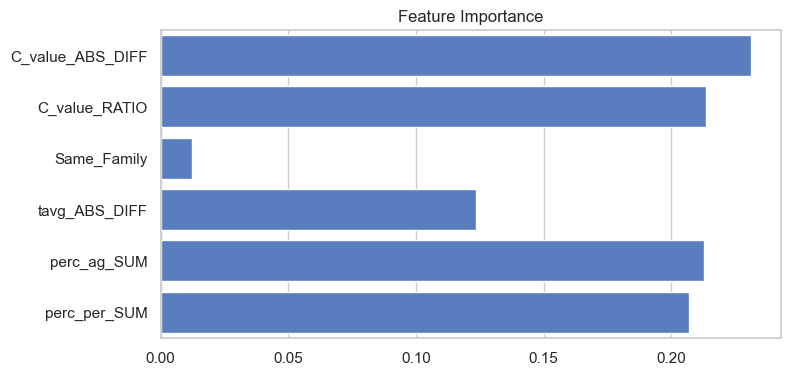

In [13]:
plt.figure(figsize=(8,4))
sns.barplot(x=rf_classifier.feature_importances_, y=features)
plt.title("Feature Importance")
plt.show()


In [14]:
joblib.dump(rf_classifier, "hybrid_model4.pkl")
joblib.dump(imputer, "imputer4.pkl")
print("Model saved!")


Model saved!


In [15]:
df_ranking = X_test.copy()
df_ranking['Probability'] = Y_pred_proba
df_ranking['Genus_A'] = df_pair.iloc[y_test.index]['Genus_A'].values
df_ranking['Genus_B'] = df_pair.iloc[y_test.index]['Genus_B'].values

top_pairs = df_ranking.sort_values(by='Probability', ascending=False).head(10)
top_pairs[['Genus_A','Genus_B','Probability']]


Genus_A       Genus_B  Probability
4439     Cassinia      Ludwigia     0.970619
1177    Persoonia      Berberis     0.968653
4063      Quercus    Cryptandra     0.940470
1151      Quercus  Haplostachys     0.938133
2020    Amsinckia        Baumea     0.934585
3956    Grevillea       Epacris     0.930274
3454      Banksia     Houstonia     0.923939
690   Elaeocarpus     Amsinckia     0.923616
933       Amsonia        Bidens     0.920537
2660     Schiedea       Wyethia     0.918215

In [16]:


# -----------------------------
# 1. Load trained model & imputer
# -----------------------------
model = joblib.load("hybrid_model4.pkl")
imputer = joblib.load("imputer4.pkl")

# -----------------------------
# 2. Load genus data
# -----------------------------
df = pd.read_csv("genus_data.csv")
numeric_cols = ['C_value', 'tavg', 'perc_ag', 'perc_per', 'HybProp', 'Hyb_Ratio']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col].fillna(df[col].median(), inplace=True)

# -----------------------------
# 3. Load Algeria GeoJSON
# -----------------------------
geojson_url = "https://raw.githubusercontent.com/fr33dz/Algeria-geojson/master/all-wilayas.geojson"
algeria_geojson = requests.get(geojson_url).json()
wilayas = [f["properties"]["name"] for f in algeria_geojson["features"]]

# -----------------------------
# 4. Generate predictions per wilaya
# -----------------------------
results = []

for wilaya in wilayas:
    
    climate = df[numeric_cols].median()

    idx_A = np.random.choice(df.index, 20)
    idx_B = np.random.choice(df.index, 20)
    mask = idx_A != idx_B
    idx_A, idx_B = idx_A[mask], idx_B[mask]

    df_pair = pd.DataFrame({
        'C_value_A': df.loc[idx_A, 'C_value'].values,
        'C_value_B': df.loc[idx_B, 'C_value'].values,
        'tavg_A': df.loc[idx_A, 'tavg'].values,
        'tavg_B': df.loc[idx_B, 'tavg'].values,
        'perc_ag_A': df.loc[idx_A, 'perc_ag'].values,
        'perc_ag_B': df.loc[idx_B, 'perc_ag'].values,
        'perc_per_A': df.loc[idx_A, 'perc_per'].values,
        'perc_per_B': df.loc[idx_B, 'perc_per'].values,
        'Family_A': df.loc[idx_A, 'Family'].values,
        'Family_B': df.loc[idx_B, 'Family'].values,
    })

    # Compute features
    df_pair['C_value_ABS_DIFF'] = np.abs(df_pair['C_value_A'] - df_pair['C_value_B'])
    df_pair['C_value_RATIO'] = df_pair[['C_value_A', 'C_value_B']].max(axis=1) / df_pair[['C_value_A', 'C_value_B']].min(axis=1)
    df_pair['Same_Family'] = (df_pair['Family_A'] == df_pair['Family_B']).astype(int)
    df_pair['tavg_ABS_DIFF'] = np.abs(df_pair['tavg_A'] - df_pair['tavg_B'])
    df_pair['perc_ag_SUM'] = df_pair['perc_ag_A'] + df_pair['perc_ag_B']
    df_pair['perc_per_SUM'] = df_pair['perc_per_A'] + df_pair['perc_per_B']

    features = ['C_value_ABS_DIFF', 'C_value_RATIO', 'Same_Family',
                'tavg_ABS_DIFF', 'perc_ag_SUM', 'perc_per_SUM']

    X = imputer.transform(df_pair[features])
    probs = model.predict_proba(X)[:, 1]

    # Aggregate mean probability for the wilaya
    results.append({'name': wilaya, 'prob': probs.mean()})

# -----------------------------
# 5. Create DataFrame
# -----------------------------
df_map = pd.DataFrame(results)

# -----------------------------
# 6. Plot map
# -----------------------------
m = folium.Map(location=[28, 3], zoom_start=5)

folium.Choropleth(
    geo_data=algeria_geojson,
    data=df_map,
    columns=["name", "prob"],
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Predicted Hybridization Probability"
).add_to(m)

m.save("algeria_hybridization_ai_map.html")
m


C:\Users\khaak\AppData\Local\Temp\ipykernel_35528\3867420012.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


C:\Users\khaak\AppData\Local\Temp\ipykernel_35528\1337707581.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test_df)
E:\anaconda\Lib\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
E:\anaconda\Lib\site-packages\shap\plots\_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


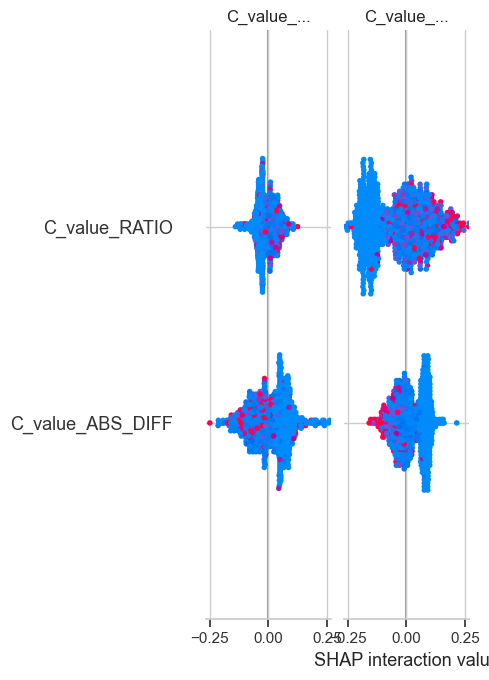

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 50

In [17]:
# ==============================================================================
# 11. SHAP EXPLAINABILITY
# ==============================================================================
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer(X_test_imputed)

X_test_df = pd.DataFrame(X_test_imputed, columns=features)

# Summary plot
shap.summary_plot(shap_values.values, X_test_df)

# Dependence plot for a feature
shap.dependence_plot("C_value_ABS_DIFF", shap_values.values, X_test_df)